In [2]:
%matplotlib inline
import os.path as op
from glob import glob
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
classes = ['accepted', 'ignored', 'rejected']
ign_codes = ['I005', 'I007', 'I010', 'I011']
rej_codes = ['I002', 'I003', 'I004', 'I006', 'I008', 'I009']
all_codes = sorted(ign_codes + rej_codes)

base_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/'

In [4]:
columns = ['label', 'failure', 'duration', 'accepted', 'rejected', 'ignored'] + all_codes
summary_df = pd.DataFrame(columns=columns)

ted_dirs = sorted(glob(op.join(base_dir, 'logging-seed*')))

for ted_dir in ted_dirs:
    label = op.basename(ted_dir).split('-seed')[-1]
    comptable = pd.read_csv(op.join(ted_dir, 'comp_table_ica.txt'), sep='\t')

    log_df = pd.read_csv(op.join(ted_dir, 'runlog.tsv'),
                         sep='\t', header=None,
                         names=['time', 'module', 'level', 'message'])
    log_df['time'] = pd.to_datetime(log_df['time'])
    duration = log_df['time'].iloc[-1] - log_df['time'].iloc[0]
    minutes = duration.total_seconds() / 60.
    failure = any(log_df['message'].str.contains('ICA failed to converge'))
    rationales = comptable['rationale'].tolist()
    classifications = comptable['classification'].tolist()
    rationales = [[m for m in r.split(';') if m] for r in rationales if isinstance(r, str)]
    rationales = [item for sublist in rationales for item in sublist]
    counter = dict(Counter(rationales))
    counter['label'] = label

    counter2 = dict(Counter(classifications))
    for k, v in counter2.items():
        counter[k] = v

    counter['failure'] = failure
    counter['duration'] = minutes
    summary_df = summary_df.append(counter, ignore_index=True).fillna(0)

In [5]:
summary_df

,label,failure,duration,accepted,rejected,ignored,I002,I003,I004,I005,...,I010,I011,Rho>Kappa or more significant voxels in S0 model than R2 model,S0 dice is higher than R2 dice and high variance explained,candartA,candartB,ign_add0,low variance,signal-noise_t < 0 and high variance explained,midk
0,0,True,11.150000,57,17,22,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,1.0,5.0,3.0,1.0,21.0,5.0,0.0
1,1,True,13.533333,56,14,26,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,1.0,1.0,2.0,1.0,25.0,5.0,1.0
2,10,True,9.600000,55,17,24,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,2.0,3.0,3.0,1.0,23.0,5.0,0.0
3,2,False,4.516667,49,14,33,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,1.0,2.0,2.0,0.0,33.0,7.0,1.0
4,3,True,13.116667,58,16,22,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,2.0,1.0,2.0,0.0,22.0,7.0,0.0
5,4,True,10.950000,54,16,26,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,1.0,5.0,1.0,1.0,25.0,6.0,0.0
6,5,False,3.233333,51,17,28,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,0.0,4.0,0.0,28.0,6.0,2.0
7,6,True,9.366667,52,17,27,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,1.0,3.0,2.0,0.0,27.0,7.0,2.0
8,7,True,9.400000,59,17,20,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,1.0,1.0,3.0,0.0,20.0,8.0,2.0
9,8,True,9.550000,48,16,32,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,0.0,2.0,3.0,0.0,32.0,6.0,1.0


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


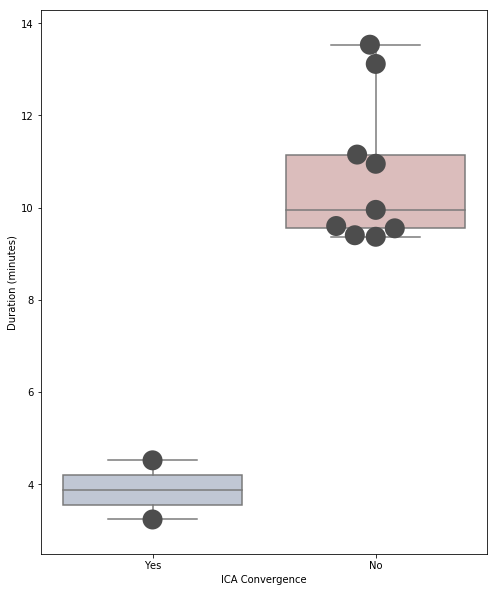

In [10]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="failure", y="duration", data=summary_df,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="failure", y="duration", data=summary_df,
              size=20, color=".3", linewidth=0)

ax.set_ylabel('Duration (minutes)')
ax.set_xlabel('ICA Convergence?')
ax.set_xticklabels(['Yes', 'No'])
fig.show()

In [38]:
clf_df = summary_df.melt(value_vars=['accepted', 'rejected', 'ignored'],
                         var_name='classification', value_name='n components',
                         id_vars=['label', 'failure'])
clf_df2 = summary_df.melt(value_vars=['accepted', 'rejected', 'ignored'],
                         var_name='classification', value_name='n components',
                         id_vars=['label'])
clf_df2['failure'] = 'Total'
df2 = pd.concat((clf_df, clf_df2))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


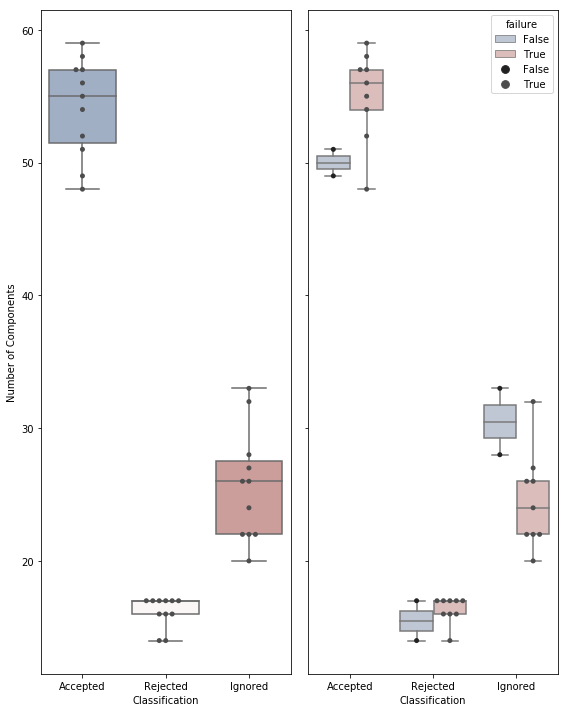

In [59]:
#sns.swarmplot(x='classification', y='n components', data=clf_df)
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(8, 10))
sns.boxplot(x="classification", y="n components", data=clf_df,
            whis="range", palette="vlag", ax=axes[0])

# Add in points to show each observation
sns.swarmplot(x="classification", y="n components", data=clf_df,
              size=5, color=".3", linewidth=0, ax=axes[0])

sns.boxplot(x="classification", y="n components", data=clf_df,
            whis="range", palette="vlag", ax=axes[1], hue='failure')

# Add in points to show each observation
sns.swarmplot(x="classification", y="n components", data=clf_df,
              size=5, color=".3", linewidth=0, ax=axes[1], hue='failure', dodge=True)

axes[0].set_ylabel('Number of Components')
axes[0].set_xlabel('Classification')
axes[1].set_xlabel('Classification')
axes[1].set_ylabel('')
axes[0].set_xticklabels([l.get_text().title() for l in ax.get_xticklabels()])

fig.tight_layout()
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


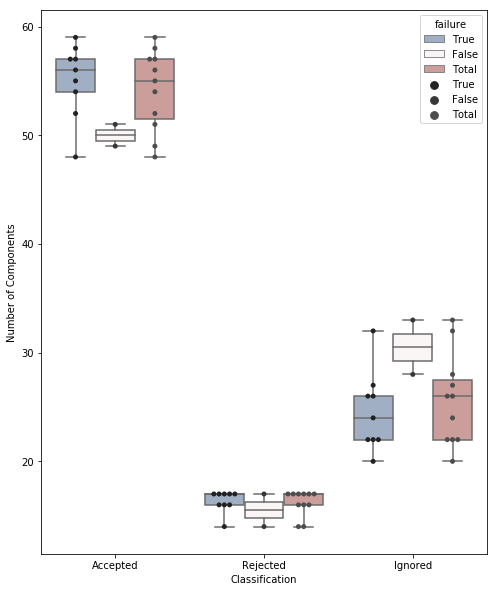

In [45]:
#sns.swarmplot(x='classification', y='n components', data=clf_df)
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="classification", y="n components", data=df2,
            whis="range", palette="vlag", hue='failure')

# Add in points to show each observation
sns.swarmplot(x="classification", y="n components", hue='failure', data=df2,
              size=5, color=".3", linewidth=0, dodge=True)

ax.set_ylabel('Number of Components')
ax.set_xlabel('Classification')
ax.set_xticklabels([l.get_text().title() for l in ax.get_xticklabels()])
fig.show()